# Pipeline for Training Faster R-CNN Object Detection Models with PyTorch

Import Libraries and check GPU

In [9]:
import matplotlib.pyplot as plt
import cv2
import os
import torch, torchvision
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO
 
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
 
print(device)
"""
Output must be--> device(type='cuda')
"""


cuda


"\nOutput must be--> device(type='cuda')\n"

# Clone the PyTorch Vision Repository and Copy Detection Utilities

First clone PyTorch vision repository from terminal:
git clone https://github.com/pytorch/vision.git

Then copy these files to folder where your training script is located:

- references/detection/utils.py
- references/detection/transforms.py
- references/detection/coco_eval.py
- references/detection/engine.py
- references/detection/coco_utils.py

# Custom PyTorch Dataset Class for COCO Format

In [ ]:
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoDetectionDataset(Dataset):
    # Init function: loads annotation file and prepares list of image IDs
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms
 
    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)
 
    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")
 
        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)
 
        # Extract bounding boxes and labels from annotations
        boxes = []
        labels = []
        for obj in annotations:
            xmin, ymin, width, height = obj['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(obj['category_id'])
 
        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor([obj['area'] for obj in annotations],    dtype=torch.float32)
        iscrowd = torch.as_tensor([obj.get('iscrowd', 0) for obj in annotations], dtype=torch.int64)
 
        # Package everything into a target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
 
        # Apply transforms if any were passed
        if self.transforms:
            image = self.transforms(image)
 
        return image, target

# Create Train and Validation sets

Don’t forget to change:
- image_dir 
- annotation_path 

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
 
# Transform PIL image --> PyTorch tensor
def get_transform():
    return ToTensor()
 
# Load training dataset
train_dataset = CocoDetectionDataset(
    image_dir="football-players-detection/train", 
    annotation_path="football-players-detection/train/_annotations.coco.json",
    transforms=get_transform()
)
 
# Load validation dataset
val_dataset = CocoDetectionDataset(
    image_dir="football-players-detection/valid",
    annotation_path="football-players-detection/valid/_annotations.coco.json",
    transforms=get_transform()
)
 
# Load dataset with DataLoaders, you can change batch_size 
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


# Display Sample Images from the DataLoader Objects

It is good practice to check some annotations and labels before starting training.

In [ ]:
# Get one batch
images, targets = next(iter(train_loader))
 
# loop through one batch and draw bounding boxes and labels
for i in range(len(images)):
    # CxHxW --> HxWxC
    image = images[i].permute(1, 2, 0).numpy()   
    # Rescale
    image = (image * 255).astype(np.uint8)   
    # Convert RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
     
    # get bounding box coordinates and labels
    boxes = targets[i]['boxes']
    labels = targets[i]['labels']
 
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"Class {label.item()}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
 
    # Show image with bboxes using matplotlib
    plt.figure(figsize=(16, 12))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Sample {i + 1}")
    plt.show()

# Load a Pre-trained Faster R-CNN Model

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# Load a pre-trained Faster R-CNN model with ResNet50 backbone and FPN, , you change this 
model =torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
# Number of classes in the dataset (including background)
# +1 for bg class
num_classes = len(train_dataset.coco.getCatIds()) + 1 
 
# Number of input features for the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features
 
"""  
Number of classes must be equal to your label number
"""
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
# Move the model to the GPU for faster training
model.to(device)

# Initializing the optimizer

You can change this parameters:

- lr(learning rate) 
- momentum
- weight_decay

In [ ]:
# Get parameters that require gradients (the model's trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
 
# Define the optimizer SGD(Stochastic Gradient Descent) 
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# Training loop

In [ ]:
from engine import train_one_epoch, evaluate
 
# Number of epochs for training
num_epochs = 10
 
# Loop through each epoch
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
 
    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training
 
    # Evaluate the model only on the validation dataset, not training
    evaluate(model, val_loader, device=device)  # Using val_loader for evaluation
 
    # save the model after each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")


# Test on a test image

c:\Users\hasan\anaconda3\envs\MV25\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hasan\anaconda3\envs\MV25\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


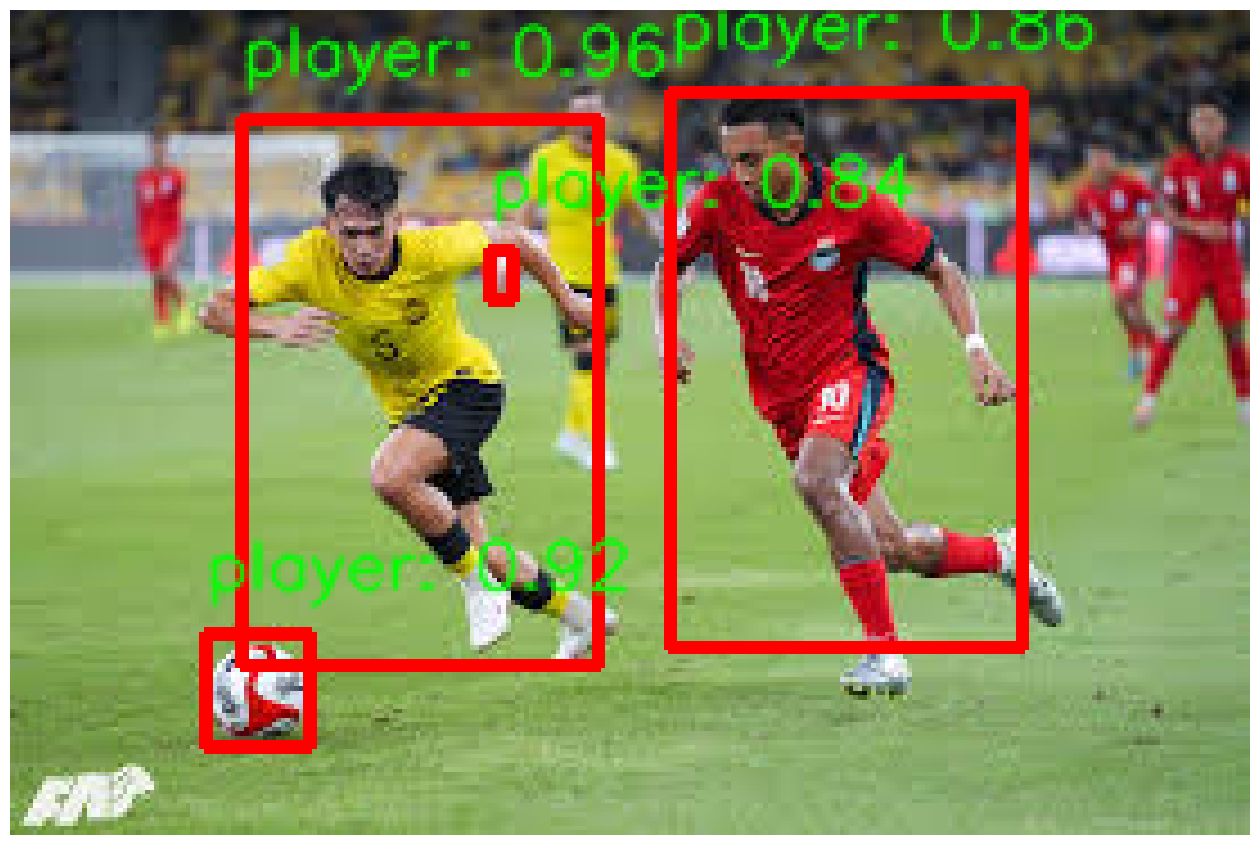

In [8]:
from torchvision import models, transforms
 
# class names
label_list= ["","ball", "goalkeeper", "player", "referee",""]
 
# Number of classes (include background)
num_classes = 6   # this has to be 5 in normally, but because of some labeling issues in dataset this is 6.
 
# Load the same model 
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
 
# Load trained Faster R-CNN model
model.load_state_dict(torch.load(r"model_epoch_10.pth"))
model.eval()
 
# Load image with OpenCV and convert to RGB
img_path = r"test_image.jpeg" # CHANGE this to your image path
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)
 
 
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0)
 
# Inference
with torch.no_grad():
    predictions = model(image_tensor)
 
# detection data
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']
 
"""
Higher threshold give you more accurate detections, 
but number of predictions is reduced; there is a simple trade-off
"""
threshold = 0.8
for i in range(len(boxes)):
    if scores[i] > threshold:
        box = boxes[i].cpu().numpy().astype(int)
        label = label_list[labels[i]]
        score = scores[i].item()
 
         
        text = f"{label}: {score:.2f}"
        cv2.putText(image_bgr, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 255, 0), 1, cv2.LINE_AA)
 
        # Draw bbox and label
        cv2.rectangle(image_bgr, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
 
 
# Convert BGR --> RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
 
# Show image with larger figure size
plt.figure(figsize=(16, 12)) 
plt.imshow(image_rgb)
plt.axis('off')
plt.show()